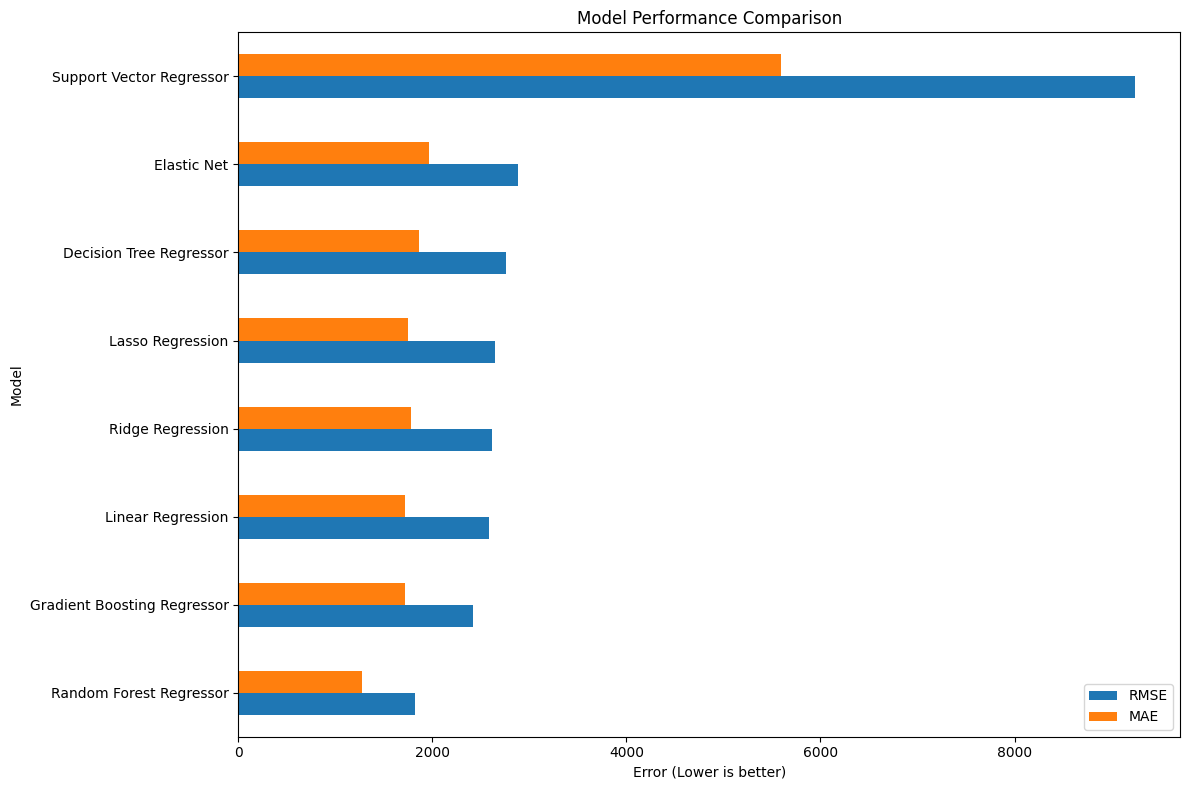

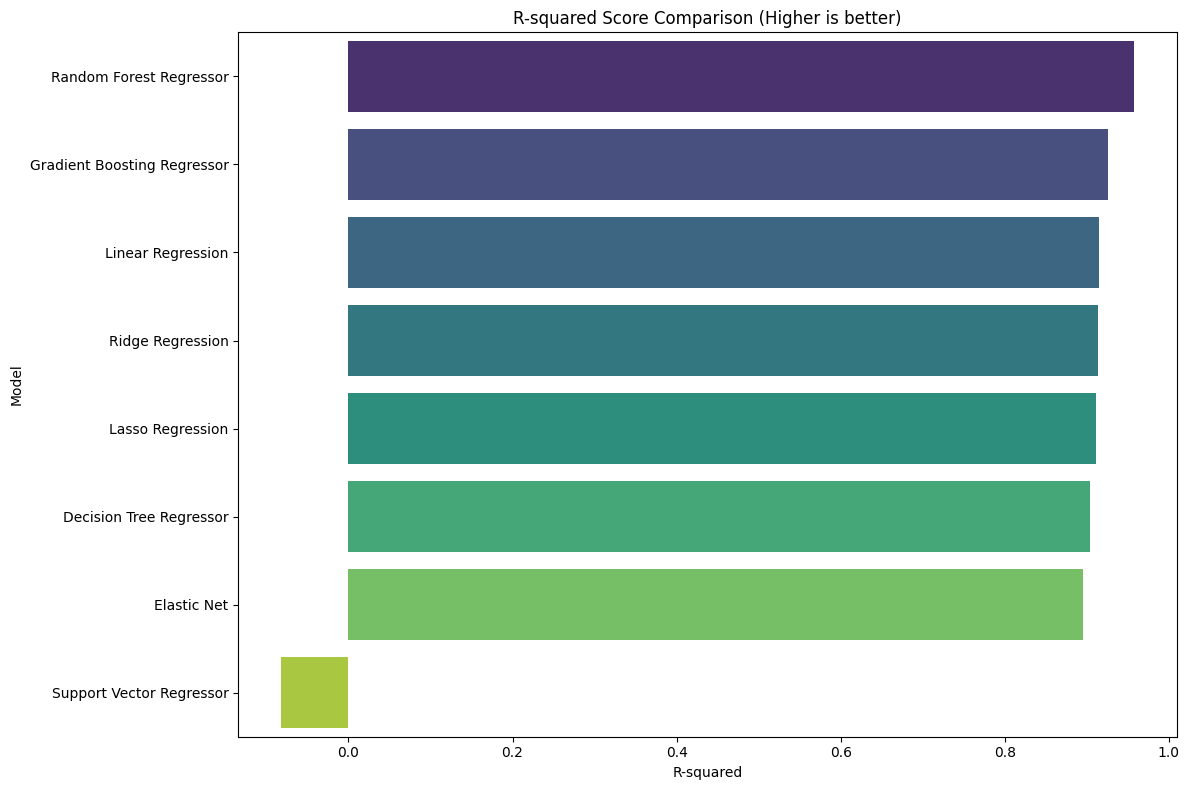

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('CarPrice_Assignment (1).csv')
except FileNotFoundError:
    print("Error: The file 'CarPrice_Assignment (1).csv' was not found.")
    exit()

# --- Feature Engineering and Preprocessing ---
# Extract car brand from 'CarName'
df['CarName'] = df['CarName'].apply(lambda x: x.split(' ')[0])

# Fix some inconsistent brand names
df['CarName'] = df['CarName'].str.replace('maxda', 'mazda')
df['CarName'] = df['CarName'].str.replace('porcshce', 'porsche')
df['CarName'] = df['CarName'].str.replace('vokswagen', 'volkswagen')
df['CarName'] = df['CarName'].str.replace('vw', 'volkswagen')
df['CarName'] = df['CarName'].str.replace('toyouta', 'toyota')

# Drop the 'car_ID' and 'symboling' columns as they are not needed for prediction
df = df.drop(['car_ID', 'symboling'], axis=1)

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features (important for some models like SVR, Ridge, Lasso)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Model Selection ---
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=0.1, max_iter=10000)),
    ('Elastic Net', ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('Random Forest Regressor', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('Support Vector Regressor', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
]

# --- Model Training and Evaluation ---
results = []
for name, model in models:
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Support Vector Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R-squared': r2, 'MAE': mae})

results_df = pd.DataFrame(results)
results_df.sort_values(by='RMSE', inplace=True)

# --- Visualization of Results ---
fig, ax = plt.subplots(figsize=(12, 8))
results_df.set_index('Model').plot(kind='barh', y=['RMSE', 'MAE'], ax=ax, title='Model Performance Comparison')
plt.xlabel('Error (Lower is better)')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('model_comparison.png')

plt.figure(figsize=(12, 8))
sns.barplot(x='R-squared', y='Model', data=results_df.sort_values(by='R-squared', ascending=False), palette='viridis')
plt.title('R-squared Score Comparison (Higher is better)')
plt.xlabel('R-squared')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('r_squared_comparison.png')

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
try:
    df = pd.read_csv('CarPrice_Assignment (1).csv')
except FileNotFoundError:
    print("Error: The file 'CarPrice_Assignment (1).csv' was not found.")
    exit()

# --- Feature Engineering and Preprocessing ---
# Extract car brand from 'CarName'
df['CarName'] = df['CarName'].apply(lambda x: x.split(' ')[0])

# Fix some inconsistent brand names
df['CarName'] = df['CarName'].str.replace('maxda', 'mazda')
df['CarName'] = df['CarName'].str.replace('porcshce', 'porsche')
df['CarName'] = df['CarName'].str.replace('vokswagen', 'volkswagen')
df['CarName'] = df['CarName'].str.replace('vw', 'volkswagen')
df['CarName'] = df['CarName'].str.replace('toyouta', 'toyota')

# Drop the 'car_ID' and 'symboling' columns
df = df.drop(['car_ID', 'symboling'], axis=1)

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Hyperparameter Tuning with GridSearchCV ---
# Define the model to tune
model = RandomForestRegressor(random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use GridSearchCV to find the best parameters
# Scoring is set to 'neg_mean_squared_error' to find the lowest RMSE, as GridSearchCV finds the max score
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

print("Starting Grid Search for Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding best score
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print("\n--- Hyperparameter Tuning Results ---")
print(f"En iyi parametreler: {best_params}")
print(f"En iyi çapraz doğrulama RMSE'si: {best_rmse:.2f}")

# Optional: Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test verisi üzerinde RMSE: {test_rmse:.2f}")

Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

--- Hyperparameter Tuning Results ---
En iyi parametreler: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
En iyi çapraz doğrulama RMSE'si: 2435.18
Test verisi üzerinde RMSE: 1804.60
